<a href="https://colab.research.google.com/github/teegwende/WQPandEntitiesDensity/blob/main/genergraphEval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
from pandas import read_csv, DataFrame
import pandas as pd

# df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/predictions.csv', index_col='periode', parse_dates=True)
df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/predictionsExtin.csv', index_col='periode', parse_dates=True)

In [3]:
#Affaiblissement


def affaiblissement(listemasses,alpha=0):
  # print(listemasses["A"],listemasses["B"],listemasses["A_B"])
  listemassesAffaiblies={} 
  listemassesAffaiblies["A"]=(1-alpha)*listemasses["A"]
  listemassesAffaiblies["B"]=(1-alpha)*listemasses["B"]
  listemassesAffaiblies["A_B"]=((1-alpha)*listemasses["A_B"])+alpha
  return listemassesAffaiblies
  
################################################################################

#Combinaison (A REVENIR SUR LE CALCUL DU DEGRE DE CONFLIT)
def Combinaison(listemasses1,listemasses2):

  import pandas as pd
  matricefusion=[]
  calcinter=[]
  degConflit=0
  sumA=0
  sumB=0
  sumAB=0

#BLOC d'instructions pour faire le calcul des masses combinées et du degré de conflit
  for etat1, m1 in listemasses1.items():
    calcinter=[]
    if etat1=='A':
      for etat2,m2 in listemasses2.items():
        if not ((etat1 in etat2 or etat2 in etat1) ):
          degConflit+=m1*m2

        calcinter.append(round(m1*m2,3))
        if (etat2=='A' or etat2=='A_B'):
          sumA+=m1*m2

    if etat1=='B':
      for etat2,m2 in listemasses2.items():
        if not ((etat1 in etat2 or etat2 in etat1) ):
          degConflit+=m1*m2

        calcinter.append(round(m1*m2,3))
        if (etat2=='B' or etat2=='A_B'):
          sumB+=m1*m2

    if etat1=='A_B':
      for etat2,m2 in listemasses2.items():
        if not ((etat1 in etat2 or etat2 in etat1) ):
          degConflit+=m1*m2

        calcinter.append(round(m1*m2,3))
        if etat2=='A':
          sumA+=m1*m2
        if etat2=='B':
          sumB+=m1*m2
        if etat2=='A_B':
          sumAB+=m1*m2

    matricefusion.append(calcinter)
  listem12={'A':sumA/(1-degConflit),'B':sumB/(1-degConflit),'A_B':sumAB/(1-degConflit)}
  # print("degConflit=",degConflit)
  return matricefusion,listem12

################################################################################

def affichagematricefusion(matricefusion,listemasses1,listemasses2):
  # resultmat,listem12=Combinaison(listemasses1,listemasses2)
  lescolonnes=[]
  leslignes=[]

  #BLOC d'instructions pour former les lignes et les colonnes du dataframe
  for etat1, m1 in listemasses1.items():
    nomcol=etat1+" ("+str(m1)+")"
    lescolonnes.append(nomcol)

  for etat2, m2 in listemasses2.items():
    nomligne=etat2+' ('+str(m2)+')'
    leslignes.append(nomligne)


  df = pd.DataFrame(matricefusion)
  df.columns=lescolonnes
  df.index=leslignes

  # print(df)

################################################################################

#Decision
def decision(listesmasses12):
  decA=0
  decB=0
  decAB=0
  for etat,m12 in listesmasses12.items():
    # print("etat =",etat)
    # print("m12 =",m12)
    if 'A' in etat :
      decA+=m12
    if 'B' in etat :
      decB+=m12
    if 'A_B' in etat :
      decAB+=m12
    # print(decA, decB,decAB)

  # print("min",min(decA,decB,decAB))
  #print("max",max(decA,decB,decAB))
  if max(decA,decB,decAB) == decA:
    etatEau = "infeste"
  if max(decA,decB,decAB) == decB:
    etatEau = "non infeste"
  # if max(decA,decB,decAB) == decAB:
  #   etatEau = "Indecision"

  return max(decA,decB,decAB), etatEau

In [4]:
#Assignation - Combinaison et Décision
colonneDecisionFusion=[]
colonneValFusion=[]
colonneDecisionML=[]
colonneValDecML=[]
colonneDecisionMM=[]
colonneValDecMM=[]

for t,ph in zip(df['TEMP'],df['PH']):
  if (t<18 or t>32) or (ph<4 or ph>10):
    # print("letal")
    noninfeste=1
    infeste=0
    omega=1-noninfeste
    
  elif (t>=25 and t<=28) or (ph>=6.5 and ph<=8.2):
    # print("optimale")
    noninfeste=0
    infeste=70.43/100.0
    omega=1-infeste
  else:
    # print("Favorable")
    noninfeste=0
    infeste=29.57/100.0
    omega=1-infeste

  if(max(noninfeste,infeste)==infeste):
      etatEauML="infeste"
      valEtatML=infeste
      colonneDecisionML.append(etatEauML)
      colonneValDecML.append(valEtatML)

  if(max(noninfeste,infeste)==noninfeste):
      etatEauML="non infeste"
      valEtatML=noninfeste
      colonneDecisionML.append(etatEauML)
      colonneValDecML.append(valEtatML)

  listemasses1={'A':round(infeste,3),'B':round(noninfeste,3),'A_B':round(omega,3)}
  listemasses1=affaiblissement(listemasses1,0.5)


  r0=0.2

  if (r0>1):
    noninfeste2=0
    infeste2=85.22/100.0
    omega2=1-infeste2

  if (r0<1):
    noninfeste2=0
    infeste2=2.27/100.0
    omega2=1-infeste2

  if (r0==1):
    noninfeste2=0
    infeste2=0
    omega2=1-infeste2

  if(max(noninfeste2,infeste2)==infeste2):
      etatEauMM="infeste"
      valEtatMM=infeste2
      colonneDecisionMM.append(etatEauMM)
      colonneValDecMM.append(valEtatMM)

  if(max(noninfeste2,infeste2)==noninfeste2):
      etatEauMM="non infeste"
      valEtatMM=noninfeste2
      colonneDecisionMM.append(etatEauMM)
      colonneValDecMM.append(valEtatMM)

  listemasses2={'A':round(infeste2,3),'B':round(noninfeste2,3),'A_B':round(omega2,3)}
  listemasses2=affaiblissement(listemasses2,0.5)

  #APPEL FONCTION COMBINAISON
  matricefusion, listesmasses12 = Combinaison(listemasses1,listemasses2)
  #APPEL FONCTION AFFICHAGE
  affichagematricefusion(matricefusion,listemasses1,listemasses2)
  #APPEL FONCTION DECISON
  val,etateau =decision(listesmasses12)
  colonneValFusion.append(val)
  colonneDecisionFusion.append(etateau)

  #Ajout de nouvelles colonnes au dataframe

df=df.assign(EtatML=colonneDecisionML,ValDecML=colonneValDecML, EtatMM=colonneDecisionMM, valDecMM=colonneValDecMM, EtatFusion=colonneDecisionFusion,ValDecFusion=colonneValFusion)
# df=df.assign(EtatML=colonneDecisionML,ValDecML=colonneValDecML)

In [38]:
#Restreindre aux jours prédits
import matplotlib.pyplot as plt

predmois = df.loc[['2017-01-21','2017-02-21','2017-03-21']]
print(predmois.loc[:,predmois.columns.str.contains("Fusion|ML|MM")].to_latex(index = True, multirow = True))
predmoisEntites=predmois.loc[:,~predmois.columns.str.contains("Fusion|ML|MM")]
# predmois[['EtatML','Mollusques infectés']]
# predmoisML=predmois[['EtatML','ValDecML']].reset_index(drop=False)
# print(predmoisML.to_latex(index = True, multirow = True))
# predmoisresults=predmois.loc[:,predmois.columns.str.contains("Fusion")]
# predmoisEntites=predmois.loc[:,~predmois.columns.str.contains("Fusion")]

# predmoisEntites[['Mollusques infectés','PH','TEMP']]

\begin{tabular}{llrlrlr}
\toprule
{} &   EtatML &  ValDecML &   EtatMM &  valDecMM & EtatFusion &  ValDecFusion \\
periode    &          &           &          &           &            &               \\
\midrule
2017-01-21 &  infeste &    0.7043 &  infeste &    0.0227 &    infeste &           1.0 \\
2017-02-21 &  infeste &    0.7043 &  infeste &    0.0227 &    infeste &           1.0 \\
2017-03-21 &  infeste &    0.7043 &  infeste &    0.0227 &    infeste &           1.0 \\
\bottomrule
\end{tabular}



In [39]:
def predmodel(predmois,motcle):
  predmois = df.loc[['2017-01-21','2017-02-21','2017-03-21']]
  # predmois[['EtatML','Mollusques infectés']]
  predmoisresults=predmois.loc[:,predmois.columns.str.contains(motcle)].reset_index(drop=False)
  print(predmoisresults.to_latex(index = True, multirow = True))

In [40]:
predmodel(predmois,"ML")

\begin{tabular}{lllr}
\toprule
{} &    periode &   EtatML &  ValDecML \\
\midrule
0 & 2017-01-21 &  infeste &    0.7043 \\
1 & 2017-02-21 &  infeste &    0.7043 \\
2 & 2017-03-21 &  infeste &    0.7043 \\
\bottomrule
\end{tabular}



In [142]:
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np

def afficheCourbes(predmoisEntites,typeModel):
  plt.rcParams.update({'font.size': 20})
  fig, ax1 = plt.subplots(figsize=(12, 6))

  if typeModel=="ML":
    ax1.plot(predmoisEntites.index,predmoisEntites['TEMP'],marker='o')
    ax1.set_ylabel('TEMP', color='blue')
    ax1.set_xlabel("Période")
    ax1.tick_params(axis='y',colors='blue')

    ax2=ax1.twinx()
    ax2.plot(predmoisEntites.index,predmoisEntites['PH'], color='green', marker='o')
    ax2.set_ylabel('PH', color='green')
    ax2.tick_params(axis='y',colors='green')

  if typeModel=="MM":
    ax1.plot(predmoisEntites.index,predmoisEntites['Mollusques infectés'],marker='o')
    ax1.set_ylabel('Mollusques infectés', color='blue')
    ax1.set_xlabel("Période")
    ax1.tick_params(axis='y',colors='blue')

  if typeModel=="Fusion":
    ax1.plot(predmoisEntites.index,predmoisEntites['TEMP'],marker='o')
    ax1.set_ylabel('TEMP', color='blue')
    ax1.set_xlabel("Période")
    ax1.tick_params(axis='y',colors='blue')

    ax2=ax1.twinx()
    ax2.plot(predmoisEntites.index,predmoisEntites['PH'], color='green', marker='o')
    ax2.set_ylabel('PH', color='green')
    ax2.tick_params(axis='y',colors='green')


    entiteax3="Mollusques infectés"
    ax3=ax1.twinx()
    ax3.plot(predmoisEntites.index,predmoisEntites[entiteax3], color='red', marker='o')
    ax3.spines['right'].set_position(('outward',60))

    ax3.set_ylabel(entiteax3, color='red')

    ax3.tick_params(axis='y',colors='red')
    ax3.xaxis.set_major_formatter(DateFormatter("%m-%y"))
    # ax3.xaxis.set_major_locator(mdates.DayLocator())
    ax3.xaxis.set_major_locator(mdates.MonthLocator())
    ax3.xaxis.set_major_locator(plt.LinearLocator(numticks=3))
    # ax3.xaxis.set_major_locator(plt.MultipleLocator(3))
    ax3.set_xlim(predmoisEntites.index[0], predmoisEntites.index[2])
    val1 = []
    for d in predmoisEntites.index:
      d = d.strftime('%d-%m-%Y')
      val1.append(d)

    val2 = ['Etat ML','Etat MM','Etat Fusion']
    # val3 = [['infesté', 'infesté', 'infesté'],['infesté', 'infesté', 'infesté'],['infesté', 'infesté', 'infesté']]
    val3=[]
  # ax3.text(0.5, 0.5, 'infesté',
  #         style ='italic',
  #         transform=ax3.transAxes, 
  #         fontsize = 30,
  #         bbox ={'facecolor':'red',
  #               'alpha':0.6, 'pad':10})
    ax2.spines['right'].set_color('green')
    ax3.spines['right'].set_color('red')
    ax3.spines['left'].set_color('blue')

    # ax3.set_axis_off() 
    plt.xticks([])
    plt.subplots_adjust(left=0.2, bottom=0.3)
    # rcolors = plt.cm.BuPu(np.full(len(val2), 0.1))
    # ccolors = plt.cm.BuPu(np.full(len(val1), 0.1))
    table = ax3.table(cellText = val3,  
    rowLabels = val2,  
    colLabels = val1,
    cellLoc ='center')

  fig.tight_layout() # Pour la prise de l'axe décalée dans la génération réelle du graphe
  plt.savefig("/gdrive/MyDrive/traitement_ordinaire/datarep/Fusion2ndCas.pdf")
  # plt.setp(ax3.get_xticklabels(), rotation=30, ha="right")
  plt.show()

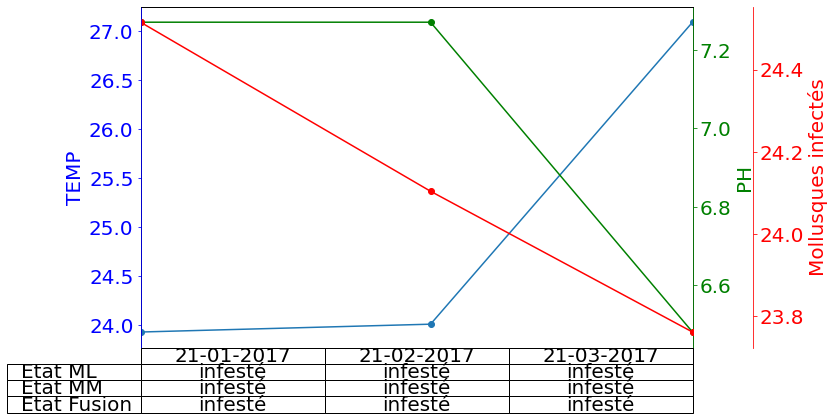

In [143]:
# predmoisEntites.index[1]
# predmoisEntites=predmoisEntites.reset_index(drop=False)
# predmoisEntites=predmoisEntites.reset_index(drop=False)
afficheCourbes(predmoisEntites,"Fusion")

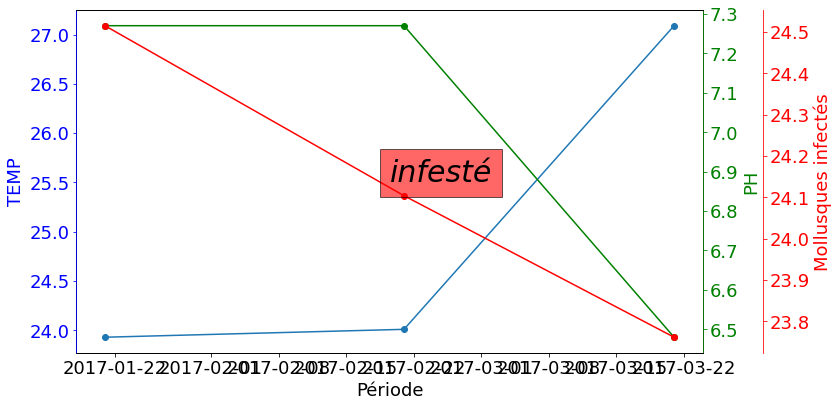

In [13]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(12, 6))

# ax1.plot(predmois.index,predmois['TEMP'],marker='o')
ax1.plot(predmois.index,predmois['TEMP'],marker='o')
ax1.set_ylabel('TEMP', color='blue')
ax1.set_xlabel("Période")
ax1.tick_params(axis='y',colors='blue')

ax2=ax1.twinx()
ax2.plot(predmois.index,predmois['PH'], color='green', marker='o')
ax2.set_ylabel('PH', color='green')
ax2.tick_params(axis='y',colors='green')

entiteax3="Mollusques infectés"
ax3=ax1.twinx()
ax3.plot(predmois.index,predmois[entiteax3], color='red', marker='o')
ax3.spines['right'].set_position(('outward',60))

ax3.set_ylabel(entiteax3, color='red')

ax3.tick_params(axis='y',colors='red')
# ax3.xaxis.set_major_formatter(DateFormatter("%y-%m-%d"))
# ax3.xaxis.set_major_locator(mdates.DayLocator(interval=7))
# ax3.xaxis.set_major_locator(mdates.MonthLocator())

# plt.xticks(rotation=45, ha='right',fontsize=14)
# ax4=ax1.twinx()
# ax4.plot(predmois.index,predmois['Mollusques infectés'], color='yellow')
# ax4.spines['left'].set_position(('outward',60))
# ax4.set_ylabel('Mollusques infectés', color='yellow')
# ax4.tick_params(axis='y',colors='yellow')
ax3.text(0.5, 0.5, 'infesté',
        style ='italic',
         transform=ax3.transAxes, 
        fontsize = 30,
        bbox ={'facecolor':'red',
               'alpha':0.6, 'pad':10})
ax2.spines['right'].set_color('green')
ax3.spines['right'].set_color('red')
ax3.spines['left'].set_color('blue')

fig.tight_layout() # Pour la prise de l'axe décalée dans la génération réelle du graphe
plt.savefig("/gdrive/MyDrive/traitement_ordinaire/datarep/eaunonInfeste.pdf")
plt.show()